# Combine neurons across sessions

Combining data across multiple recording sessions is important for statistical power. Our dataset consists of artificial and natural image conditions recorded in separate sessions. Each session is spike-sorted separately. Therefore it is possible that neurons sorted from the same recording electrode across different sessions are not the same. We want to be careful about this caveat before we combine data across sessions for each recording electrode. To this end, we take a machine-learning approach.

### Gradient-boosted Poisson regression
We train a gradient boosting regression model with Poisson targets (poisson-XGB) to predict spike counts in response to the artificial hue angle. What if neurons are not hue-tuned? To consider neurons that may be tuned to other parameters, we also include nuisance parameters in the model such as duration of stimulus, gaze position, inter-trial interval, previous trial's hue angle, etc. Including nuisance parameters ensures that we get as much predictive power as we can, so that we can meaningful compare neurons across sessions even for neurons that are not hue-tuned.

### Merging neurons by cross-prediction benchmark
Using this framework, we merge neurons as follows. First, we train poisson-XGBs on one session and predict on a held out session, for all pairs of sessions. Second, we also do a 10-fold cross-validation within each session. This results in a cross-prediction matrix with diagonal terms representing how well the model can predict held out trials on the same session, and off-diagonal terms representing how well a model trained on one session generalizes to another session.

### Ensuring natural sessions contain the same neuron as artificial sessions
We want to make sure that when we compare the tuning properties across artificial and natural conditions, we are indeed comparing the same neuron. To this end, we take the following conservative approach. Once we merge neurons across artificial sessions, we take only natural sessions that were recorded in between the artificial sessions constituting a merged neuron. We treat all these sessions as having the same neuron.

### Imports

In [1]:
# compute
import numpy as np
import pandas as pd

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from spykes.neuropop import NeuroPop
from spykes.neurovis import NeuroVis

# local
import V4pyutils as V4

/opt/anaconda/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-t

## File i/o and Data Munging

### Read excel file with list of session files

In [2]:
h5path = '../V4pydata/H5data/M3/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M3 = data[data['Animal']=='M3']
data_M3

,Animal,Natural,Hue,Ori,RF
7,M3,Ro150125_s83a_FreeViewPic_0004,Ro150126_s83a_huecircle_0003,Ro150126_s83a_v4fv_orituning_0002,Ro150126_s83a_rfMapping_0001
8,M3,Ro150125_s83a_FreeViewPic_0005,Ro150126_s83a_huecircle_0003,Ro150126_s83a_v4fv_orituning_0002,Ro150126_s83a_rfMapping_0001
9,M3,Ro150127_s84a_FreeViewPic_0001,Ro150127_s84a_huecircle_0003,Ro150127_s84a_v4fv_orituning_0002,Ro150127_s84a_rfMapping_0001
10,M3,Ro150128_s85a_FreeViewPic_0001,Ro150128_s85a_huecircle_0003,Ro150128_s85a_v4fv_orituning_0002,Ro150128_s85a_rfMapping_0001
11,M3,Ro150129_s86a_FreeViewPic_0001,Ro150129_s86a_huecircle_0003,Ro150129_s86a_v4fv_orituning_0002,Ro150129_s86a_rfMapping_0001
12,M3,Ro150129_s86a_FreeViewPic_0005,Ro150129_s86a_huecircle_0003,Ro150129_s86a_v4fv_orituning_0002,Ro150129_s86a_rfMapping_0001
13,M3,Ro150210_s87a_FreeViewPic_manyimage_0004,Ro150210_s87a_huecircle_0003,Ro150210_s87a_v4fv_orituning_0002,Ro150210_s87a_rfMapping_0001
14,M3,Ro150211_s88a_FreeViewPic_manyimages_0004,Ro150211_s88a_huecircle_0003,Ro150211_s88a_v4fv_orituning_0002,Ro150211_s88a_rfMapping_0001
15,M3,Ro150211_s88a_FreeViewPic_manyimages_0005,Ro150211_s88a_huecircle_0003,Ro150211_s88a_v4fv_orituning_0002,Ro150211_s88a_rfMapping_0001
16,M3,Ro150212_289a_FreeViewPic_manyimages_0004,Ro150212_289a_huecircle_0003,Ro150212_289a_v4fr_orituning_0002,Ro150212_289a_rfMapping_0001


### Read session files and get predictors and spike counts into a useful data frame

In [3]:
sessions =dict()
for i, f in enumerate(np.sort(np.unique(data_M3['Hue']))):
    sessions[i] = f
sessions

{0: u'Ro150126_s83a_huecircle_0003',
 1: u'Ro150127_s84a_huecircle_0003',
 2: u'Ro150128_s85a_huecircle_0003',
 3: u'Ro150129_s86a_huecircle_0003',
 4: u'Ro150210_s87a_huecircle_0003',
 5: u'Ro150211_s88a_huecircle_0003',
 6: u'Ro150212_289a_huecircle_0003',
 7: u'Ro150213_s90a_huecircle_0003',
 8: u'Ro150216_s91a_huecircle_0003',
 9: u'Ro150217_s92a_huecircle_0003'}

In [4]:
dfs = list()
for s in sessions:
    fname = h5path + sessions[s] + '_nev.h5'
    df0 = V4.art_file_to_df(session_number=s, 
                            session_name=fname, 
                            neurons=None, 
                            window=[50, 300])
    dfs.append(df0)
    print sessions[s], len(df0), "fixations", len(df0.filter(regex="spikes").columns), "neurons"

Ro150126_s83a_huecircle_0003 738 fixations 53 neurons
Ro150127_s84a_huecircle_0003 745 fixations 52 neurons
Ro150128_s85a_huecircle_0003 749 fixations 59 neurons
Ro150129_s86a_huecircle_0003 805 fixations 61 neurons
Ro150210_s87a_huecircle_0003 732 fixations 66 neurons
Ro150211_s88a_huecircle_0003 733 fixations 73 neurons
Ro150212_289a_huecircle_0003 673 fixations 65 neurons
Ro150213_s90a_huecircle_0003 552 fixations 75 neurons
Ro150216_s91a_huecircle_0003 779 fixations 75 neurons
Ro150217_s92a_huecircle_0003 667 fixations 79 neurons


### Concatenate across sessions

In [5]:
# Concatenate
df = pd.concat((dfs))

# Reorder
reordered = list()
reordered.extend(tuple([c for c in dfs[0].columns if 'predictors' in c]))
reordered.extend(tuple(np.sort([c for c in df.columns if 'spikes' in c])))
reordered.extend(tuple([c for c in df.columns if 'session' in c]))
df = df[reordered]
print len(df.filter(regex='spikes').columns), "neurons across sessions"
df.head()



107 neurons across sessions


,predictors.onset_times,predictors.offset_times,predictors.col,predictors.row,predictors.hue,predictors.hue_prev,predictors.stim_dur,predictors.off_to_onset_times,spikes.0101,spikes.0201,...,spikes.9002,spikes.9100,spikes.9102,spikes.9200,spikes.9202,spikes.9300,spikes.9400,spikes.9600,session.name,session.number
0,1.376900,1.565233,370.0,328.0,1.822645,-999.000000,0.188333,-999.000000,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,../V4pydata/H5data/M3/Ro150126_s83a_huecircle_...,0
1,1.694233,1.893600,370.0,332.0,-1.336950,1.822645,0.199367,0.129000,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,2.0,../V4pydata/H5data/M3/Ro150126_s83a_huecircle_...,0
2,2.004167,2.184233,378.0,343.0,-2.928811,-1.336950,0.180067,0.110567,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,3.0,../V4pydata/H5data/M3/Ro150126_s83a_huecircle_...,0
3,3.884300,4.081467,370.0,330.0,-2.863301,-2.928811,0.197167,1.700067,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,6.0,../V4pydata/H5data/M3/Ro150126_s83a_huecircle_...,0
4,4.194367,4.393767,370.0,329.0,-0.836567,-2.863301,0.199400,0.112900,NaN,NaN,...,NaN,2.0,NaN,2.0,NaN,NaN,NaN,1.0,../V4pydata/H5data/M3/Ro150126_s83a_huecircle_...,0


In [6]:
df.to_pickle('../02-preprocessed_data/merged_art_data_across_sessions')

## Merge neurons across sessions

### Predict across sessions

In [6]:
from tqdm import tqdm

Models_art = dict()
#Models_art['hue'] = dict()
#Models_art['hue']['covariates'] = ['predictors.hue']

Models_art['all'] = dict()
Models_art['all']['covariates'] = ['predictors.hue', 
                                   'predictors.col', 
                                   'predictors.row', 
                                   'predictors.hue_prev', 
                                   'predictors.stim_dur', 
                                   'predictors.off_to_onset_times']

#for all neurons
cross_pred_matrix = dict()

neuron_names = list(df.filter(regex="spikes").columns)
#neuron_names = ['spikes.0700', 'spikes.9100']

df_sessions_of_interest = df
#df_sessions_of_interest = df.loc[df['session.number'].isin([0, 1, 2])]

for neuron_name in neuron_names:
    print 'neuron %s' % neuron_name
    cross_pred_matrix[neuron_name] = V4.predict_across_sessions(df_sessions_of_interest, 
                                                                neuron_name, 
                                                                Models=Models_art, 
                                                                verbose=0, 
                                                                plot=False)

neuron spikes.0101
neuron spikes.0201
neuron spikes.0301
neuron spikes.0302
neuron spikes.0400


KeyboardInterrupt: 

### Visualize an example neuron across sessions

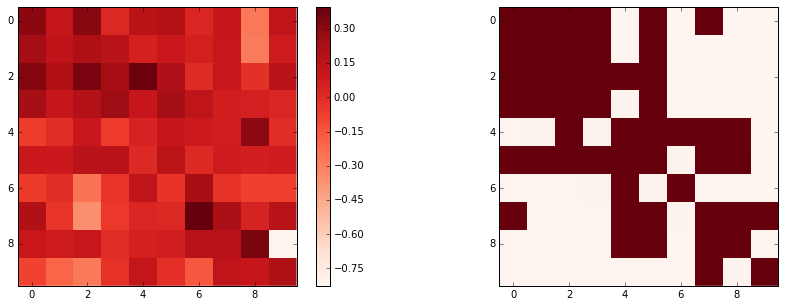

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(cross_pred_matrix['spikes.0700'], interpolation='none', cmap='Reds')
plt.colorbar()
plt.subplot(122)
M = (cross_pred_matrix['spikes.0700'] > 0.)
plt.imshow(M * M.T, interpolation='none', cmap='Reds')
plt.show()

### Combine sessions into blocks

In [9]:
Blocks = dict()
for neuron_name in cross_pred_matrix:
    M = (cross_pred_matrix[neuron_name] > 0.)
    Blocks[neuron_name] = V4.find_all_blocks(M)
Blocks

{'spikes.0101': [(2, 3), (7,)],
 'spikes.0201': [],
 'spikes.0301': [(0,), (4,), (6,), (7,), (8, 9)],
 'spikes.0302': [array([9])],
 'spikes.0400': [array([5]), array([0]), array([9]), array([4])],
 'spikes.0500': [(0,), (2,), (3, 4, 5), (4, 5, 6), (8,), (9,)],
 'spikes.0600': [(2, 3, 4, 5), (8,), (9,)],
 'spikes.0602': [array([9])],
 'spikes.0700': [(0, 1, 2, 3), (4, 5), (6,), (7, 8), (9,)],
 'spikes.0702': [array([1]), array([9]), array([4])],
 'spikes.0800': [array([0]),
  array([2]),
  array([8]),
  array([3]),
  array([9]),
  array([4]),
  array([6]),
  array([7])],
 'spikes.0900': [(0, 1, 2, 3, 4, 5), (3, 4, 5, 6, 7), (7, 8, 9)],
 'spikes.1000': [array([5])],
 'spikes.1100': [(0,), (2, 3), (4,), (5,), (6,), (8,), (9,)],
 'spikes.1101': [array([3])],
 'spikes.1200': [array([5])],
 'spikes.1300': [array([2]), array([0]), array([3]), array([6]), array([1])],
 'spikes.1400': [(4, 5), (6, 7), (7, 8, 9)],
 'spikes.1401': [],
 'spikes.1500': [(0,), (1,), (2,), (3,), (4,), (5, 6, 7), (8,

### Reject single-session blocks

In [10]:
Blocks_atleast2_sessions = dict()
for i in np.sort(Blocks.keys()):
    Blocks_atleast2_sessions[i] = [j for j in Blocks[i] if len(j)>1]
Blocks_atleast2_sessions

{'spikes.0101': [(2, 3)],
 'spikes.0201': [],
 'spikes.0301': [(8, 9)],
 'spikes.0302': [],
 'spikes.0400': [],
 'spikes.0500': [(3, 4, 5), (4, 5, 6)],
 'spikes.0600': [(2, 3, 4, 5)],
 'spikes.0602': [],
 'spikes.0700': [(0, 1, 2, 3), (4, 5), (7, 8)],
 'spikes.0702': [],
 'spikes.0800': [],
 'spikes.0900': [(0, 1, 2, 3, 4, 5), (3, 4, 5, 6, 7), (7, 8, 9)],
 'spikes.1000': [],
 'spikes.1100': [(2, 3)],
 'spikes.1101': [],
 'spikes.1200': [],
 'spikes.1300': [],
 'spikes.1400': [(4, 5), (6, 7), (7, 8, 9)],
 'spikes.1401': [],
 'spikes.1500': [(5, 6, 7), (8, 9)],
 'spikes.1701': [(5, 6)],
 'spikes.1901': [],
 'spikes.2101': [(4, 5)],
 'spikes.2201': [],
 'spikes.2301': [],
 'spikes.2401': [],
 'spikes.2501': [(7, 8)],
 'spikes.2601': [],
 'spikes.2701': [],
 'spikes.2801': [array([7, 8])],
 'spikes.2901': [(5, 6), (6, 7)],
 'spikes.3001': [],
 'spikes.3101': [],
 'spikes.3201': [array([4, 5]), array([7, 8])],
 'spikes.3301': [],
 'spikes.3302': [],
 'spikes.3401': [(3, 4), (4, 5)],
 'spike

### Collect a dataframe of unique neurons

In [11]:
df_neurons = pd.DataFrame(columns=['name', 
                                   'art_sessions', 
                                   'art_filenames', 
                                   'nat_sessions', 
                                   'nat_filenames'])

for neuron_id in np.sort(Blocks_atleast2_sessions.keys()):
    linked_lists = dict()
    linked_lists['nat'] = []
    linked_lists['art'] = Blocks_atleast2_sessions[neuron_id]
    
    table_entry = V4.sessions_to_table_entry(data_M3, neuron_id, linked_lists)

    if not list(df_neurons.index):
        start_idx = 0
    else:
        start_idx = df_neurons.index[-1] + 1

    for e in range(len(table_entry)):    
        df_neurons.loc[start_idx + e] = table_entry[e]

df_neurons

,name,art_sessions,art_filenames,nat_sessions,nat_filenames
0,spikes.0101,"[2, 3]","[Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...",[4],[Ro150129_s86a_FreeViewPic_0001]
1,spikes.0301,"[8, 9]","[Ro150211_s88a_huecircle_0003, Ro150212_289a_h...","[11, 12]","[Ro150216_s91a_FreeViewPic_0004, Ro150216_s91a..."
2,spikes.0500,"[3, 4, 5]","[Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...","[5, 6]","[Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a..."
3,spikes.0500,"[4, 5, 6]","[Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...","[6, 7, 8]","[Ro150210_s87a_FreeViewPic_manyimage_0004, Ro1..."
4,spikes.0600,"[2, 3, 4, 5]","[Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...","[4, 5, 6]","[Ro150129_s86a_FreeViewPic_0001, Ro150129_s86a..."
5,spikes.0700,"[0, 1, 2, 3]","[Ro150126_s83a_huecircle_0003, Ro150126_s83a_h...","[2, 3, 4]","[Ro150127_s84a_FreeViewPic_0001, Ro150128_s85a..."
6,spikes.0700,"[4, 5]","[Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...",[6],[Ro150210_s87a_FreeViewPic_manyimage_0004]
7,spikes.0700,"[7, 8]","[Ro150211_s88a_huecircle_0003, Ro150211_s88a_h...",[10],[Ro150213_s90a_FreeViewPic_0004]
8,spikes.0900,"[0, 1, 2, 3, 4, 5]","[Ro150126_s83a_huecircle_0003, Ro150126_s83a_h...","[2, 3, 4, 5, 6]","[Ro150127_s84a_FreeViewPic_0001, Ro150128_s85a..."
9,spikes.0900,"[3, 4, 5, 6, 7]","[Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...","[5, 6, 7, 8, 9]","[Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a..."


In [12]:
np.unique(df_neurons['name'])

array(['spikes.0101', 'spikes.0301', 'spikes.0500', 'spikes.0600',
       'spikes.0700', 'spikes.0900', 'spikes.1100', 'spikes.1400',
       'spikes.1500', 'spikes.1701', 'spikes.2101', 'spikes.2501',
       'spikes.2801', 'spikes.2901', 'spikes.3201', 'spikes.3401',
       'spikes.3601', 'spikes.3701', 'spikes.3801', 'spikes.3901',
       'spikes.4301', 'spikes.4401', 'spikes.4501', 'spikes.4701',
       'spikes.4901', 'spikes.5101', 'spikes.5201', 'spikes.5301',
       'spikes.5401', 'spikes.5501', 'spikes.5601', 'spikes.5801',
       'spikes.6101', 'spikes.6201', 'spikes.6400', 'spikes.7300',
       'spikes.7500', 'spikes.7800', 'spikes.8000', 'spikes.8100',
       'spikes.8300', 'spikes.8400', 'spikes.8600', 'spikes.8700',
       'spikes.8800', 'spikes.9000', 'spikes.9100', 'spikes.9200',
       'spikes.9600'], dtype=object)

In [13]:
np.unique(df_neurons['name']).shape

(49,)

In [14]:
df_neurons.to_pickle('../02-preprocessed_data/data_to_combine_across_sessions')